# ENEXIS Graduation Project

- Feature selection using lasso
- Try different models using these features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV

<a id='readpv'></a>
#### Reading of PV installed capacity & demographics dataset

In [2]:
c_path = "../data/"
v_file = "PV installed capacity & demographics-1006"

In [3]:
df = pd.read_csv(filepath_or_buffer = c_path + v_file + ".csv", encoding= 'UTF-8')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10860 entries, 0 to 10859
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       10860 non-null  int64  
 1   BU_2021                                    10860 non-null  object 
 2   BU_NAAM                                    10860 non-null  object 
 3   WK_2021                                    10860 non-null  object 
 4   WK_NAAM                                    10860 non-null  object 
 5   GM_2021                                    10860 non-null  object 
 6   GM_NAAM                                    10860 non-null  object 
 7   ProvinciecodePV                            10860 non-null  object 
 8   Provincienaam                              10860 non-null  object 
 9   Aantal aansluitingen met opwekinstallatie  10860 non-null  float64
 10  Opgesteld vermogen    

Setup the pipeline

In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

pipeline_lasso = Pipeline([
    ('impute', imputer),
    ('scaler',StandardScaler()), 
    ('model',Lasso())])

Optimize the model on the alpha hyperparameter in the specified range

In [6]:
search = GridSearchCV(pipeline_lasso,
                      {'model__alpha':np.arange(0.1,2,0.05)},
                      cv = 5, 
                      scoring="neg_mean_squared_error",
                      verbose=2, error_score="raise")

Use only the 2019 data, since that is the most complete

In [7]:
year = 'Year'
df = df[df[year]==2019]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760 entries, 3 to 10857
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       1760 non-null   int64  
 1   BU_2021                                    1760 non-null   object 
 2   BU_NAAM                                    1760 non-null   object 
 3   WK_2021                                    1760 non-null   object 
 4   WK_NAAM                                    1760 non-null   object 
 5   GM_2021                                    1760 non-null   object 
 6   GM_NAAM                                    1760 non-null   object 
 7   ProvinciecodePV                            1760 non-null   object 
 8   Provincienaam                              1760 non-null   object 
 9   Aantal aansluitingen met opwekinstallatie  1760 non-null   float64
 10  Opgesteld vermogen     

And since only one year has no variance, it can be removed from the data set

In [9]:
df = df.drop(columns=year)

Further removal of string type columns

In [10]:
string_types = df.dtypes[df.dtypes == 'object']
string_types

BU_2021            object
BU_NAAM            object
WK_2021            object
WK_NAAM            object
GM_2021            object
GM_NAAM            object
ProvinciecodePV    object
Provincienaam      object
dtype: object

In [11]:
string_type_columns = [
    'BU_2021','BU_NAAM','WK_2021',
    'WK_NAAM','GM_2021','GM_NAAM',
    'ProvinciecodePV','Provincienaam']
df = df.drop(columns=string_type_columns)

Remove columns that have derived columns

In [12]:
redundant_columns = [
    'Aantal aansluitingen met opwekinstallatie', 
    'OV_per_installatie',
    'PVinstallaties_per100houshoudens']
df = df.drop(columns=redundant_columns)

In [13]:
df.columns

Index(['Opgesteld vermogen', 'MeestVoorkomendePostcode_113',
       'HuishoudensTotaal_28', 'GemiddeldeHuishoudensgrootte_32',
       'Bevolkingsdichtheid_33', 'Woningvoorraad_34',
       'GemiddeldeWoningwaarde_35', 'PercentageEengezinswoning_36',
       'Koopwoningen_40', 'InBezitWoningcorporatie_42',
       'InBezitOverigeVerhuurders_43', 'BouwjaarVanaf2000_46',
       'GemiddeldElektriciteitsverbruikTotaal_47',
       'GemiddeldAardgasverbruikTotaal_55', 'Gemiddeld_opleidingsniveau',
       'Percent_inkomensontvangers', 'GemiddeldInkomenPerInwoner_72',
       'Bedrijfsvestigingen_per_huishuidens', 'PersonenautoSPerHuishouden_102',
       'AfstandTotSchool_108', 'MateVanStedelijkheid_115',
       'Opgesteld_vermogen_per100houshoudens'],
      dtype='object')

In [14]:
#df = df.drop(columns=['GemiddeldElektriciteitsverbruikTotaal_47', 'Woningvoorraad_34', 'Bedrijfsvestigingen_per_huishuidens'])

In [15]:
corr_matrix = df.corr().sort_values(by = 'Opgesteld_vermogen_per100houshoudens', ascending = False).transpose()
corr_matrix = corr_matrix.sort_values(by = 'Opgesteld_vermogen_per100houshoudens', ascending = False)

<AxesSubplot:>

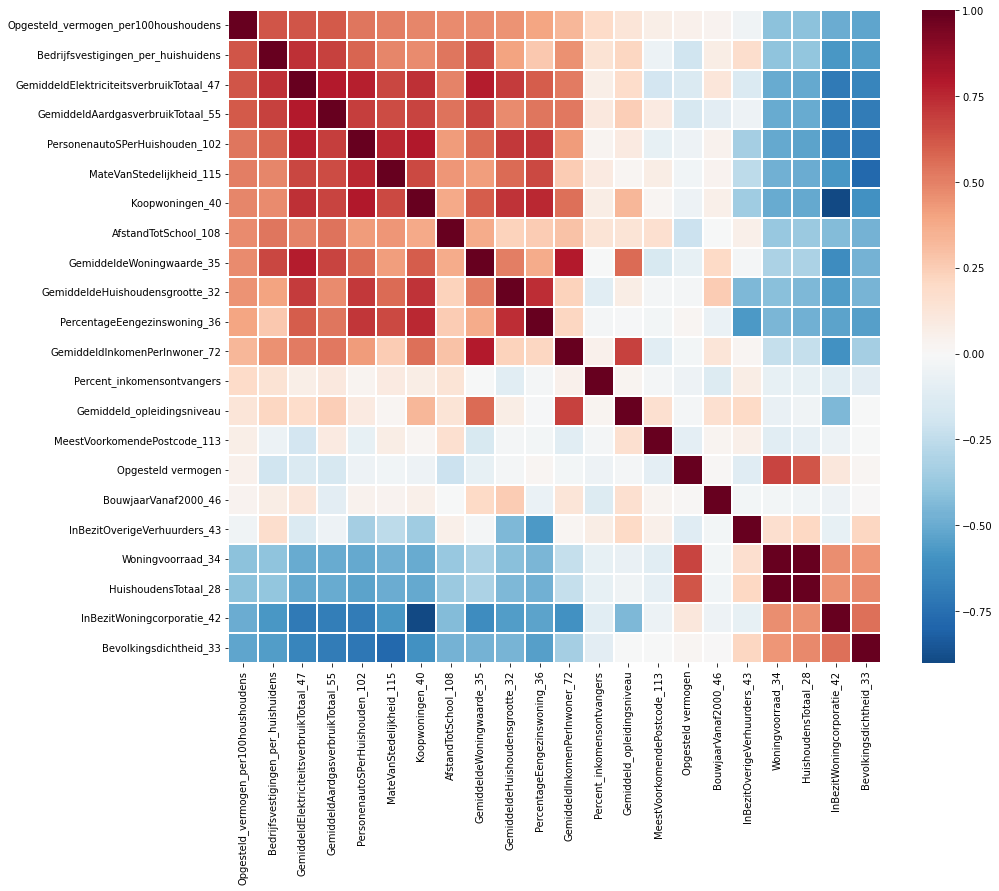

In [16]:
plt.figure(figsize = (15,12))
sns.heatmap(data = corr_matrix, annot = False, fmt='.2f', cmap = 'RdBu_r', linewidths=.1, square=True, vmax=1, center = 0)

In [17]:
opgesteld_vermogen = 'Opgesteld_vermogen_per100houshoudens'

df_y = df[opgesteld_vermogen]
df_features = df.drop(columns=opgesteld_vermogen)
df_features = df_features.drop(columns='Opgesteld vermogen')

X_train, X_test, y_train, y_test = train_test_split(df_features, df_y, test_size=0.33, random_state=123)

Do a grid search for the best features

In [18]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 38 candidates, totalling 190 fits
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................model__alpha=0.15000000000000002; total time=   0.0s
[CV] END ...................model__alpha=0.15000000000000002; total time=   0.0s
[CV] END ...................model__alpha=0.15000000000000002; total time=   0.0s
[CV] END ...................model__alpha=0.15000000000000002; total time=   0.0s
[CV] END ...................model__alpha=0.15000000000000002; total time=   0.0s
[CV] END ...................model__alpha=0.20000000000000004; total time=   0.0s
[CV] END ...................model__alpha=0.2000

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('impute', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
       1.75, 1.8 , 1.85, 1.9 , 1.95])},
             scoring='neg_mean_squared_error', verbose=2)

Check the outcome of the grid search and evaluate the coefficients at the point of the best result

In [19]:
search.best_params_

{'model__alpha': 0.40000000000000013}

In [20]:
coefficients = search.best_estimator_.named_steps['model'].coef_
coefficients

array([  6.1189844 ,  -2.26444354,   6.8988843 ,  -3.07729618,
        -0.        , -11.43544101,  -0.        ,   0.55729199,
        -0.        ,  -2.15874121,   0.        ,  21.13475755,
         8.18407015,   2.59987046,   0.94832775,  -0.        ,
        25.50962787,  -5.31647073,   6.06585673,   6.41853484])

What coefficients are NOT relevant:

In [21]:
np.array(df_features.columns)[coefficients == 0]

array(['Woningvoorraad_34', 'PercentageEengezinswoning_36',
       'InBezitWoningcorporatie_42', 'BouwjaarVanaf2000_46',
       'GemiddeldInkomenPerInwoner_72'], dtype=object)

What coefficients are relevant and should be taken into account:

In [22]:
np.array(df_features.columns)[coefficients != 0]

array(['MeestVoorkomendePostcode_113', 'HuishoudensTotaal_28',
       'GemiddeldeHuishoudensgrootte_32', 'Bevolkingsdichtheid_33',
       'GemiddeldeWoningwaarde_35', 'Koopwoningen_40',
       'InBezitOverigeVerhuurders_43',
       'GemiddeldElektriciteitsverbruikTotaal_47',
       'GemiddeldAardgasverbruikTotaal_55', 'Gemiddeld_opleidingsniveau',
       'Percent_inkomensontvangers',
       'Bedrijfsvestigingen_per_huishuidens',
       'PersonenautoSPerHuishouden_102', 'AfstandTotSchool_108',
       'MateVanStedelijkheid_115'], dtype=object)

Use the lasso model with the optimized values

In [23]:
grid_search_selected_features = np.array(df_features.columns)[coefficients != 0]

## Model using: Linear regression

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
model_lr = LinearRegression()

In [26]:
pipeline_linear_regression = Pipeline([
    ('impute', imputer),
    ('scaler',StandardScaler()), 
    ('model',model_lr)])

pipeline_linear_regression.fit(X_train, y_train)
pipeline_linear_regression.score(X_test, y_test)

0.570475563846488

In [27]:
coefs_LR_surv = pd.DataFrame(data = model_lr.coef_, index=df_features.columns, columns = ['Coef']).sort_values(by = 'Coef')
coefs_LR_surv

,Coef
GemiddeldeWoningwaarde_35,-13.860765
PersonenautoSPerHuishouden_102,-8.781537
HuishoudensTotaal_28,-7.781826
Bevolkingsdichtheid_33,-3.220857
PercentageEengezinswoning_36,-1.896768
GemiddeldInkomenPerInwoner_72,-0.769821
BouwjaarVanaf2000_46,0.098337
InBezitOverigeVerhuurders_43,0.548109
Percent_inkomensontvangers,0.942653
Gemiddeld_opleidingsniveau,4.137615


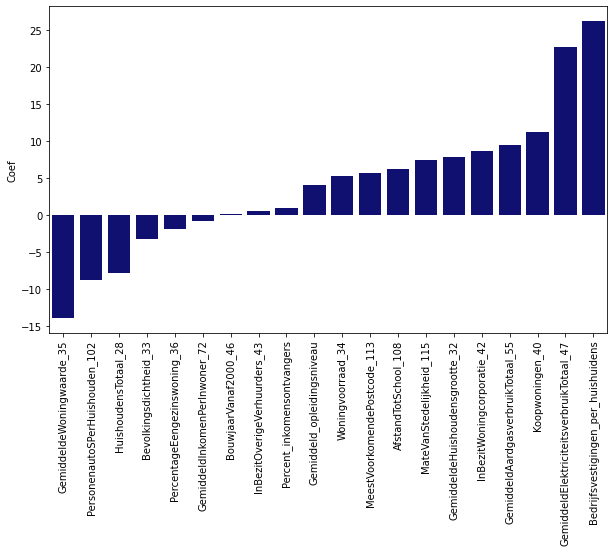

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(data = coefs_LR_surv, x = coefs_LR_surv.index, y = 'Coef', color = 'navy' )
plt.xticks(rotation = 90)
plt.show()

## Model using: Support Vector machine

In [29]:
from sklearn.svm import SVR

In [30]:
svm_regression = SVR(gamma='auto')

In [31]:
pipeline_svm = Pipeline([
    ('impute', imputer),
    ('scaler',StandardScaler()), 
    ('model',svm_regression)])

pipeline_svm.fit(X_train, y_train, model__sample_weight=None)
pipeline_svm.score(X_test, y_test)

0.19796553345010348

## Model using: Lasso (the one used for feature selection)

In [32]:
pipeline_lasso.fit(X_train, y_train)
pipeline_lasso.score(X_test, y_test)

0.554440196005545

Using LassoCV

In [33]:
pipeline_lassoCV = Pipeline([
    ('impute', imputer),
    ('scaler',StandardScaler()), 
    ('model',LassoCV())])

pipeline_lassoCV.fit(X_train, y_train, model__sample_weight=None)
pipeline_lassoCV.score(X_test, y_test)

0.5688779308189549

## Model using: Gradient Boosting Regressor

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
model_gb = GradientBoostingRegressor()

In [36]:
pipeline_rf = Pipeline([
    ('impute', imputer),
    ('scaler',StandardScaler()), 
    ('model',model_gb)])

pipeline_rf.fit(X_train, y_train, model__sample_weight=None)
pipeline_rf.score(X_test, y_test)

0.5877330470187109

In [37]:
model_gb.feature_importances_

array([0.03776121, 0.04103228, 0.01066458, 0.45618668, 0.02886646,
       0.00672865, 0.0107188 , 0.03064316, 0.00596865, 0.00281468,
       0.00901669, 0.08211184, 0.01131712, 0.00363044, 0.09722229,
       0.0234938 , 0.05522484, 0.07190353, 0.00395762, 0.01073668])

In [38]:
coefs_gb = pd.DataFrame(data = model_gb.feature_importances_, index=df_features.columns, columns = ['Coef']).sort_values(by = 'Coef')
coefs_gb

,Coef
InBezitOverigeVerhuurders_43,0.002815
Gemiddeld_opleidingsniveau,0.003630
AfstandTotSchool_108,0.003958
InBezitWoningcorporatie_42,0.005969
GemiddeldeWoningwaarde_35,0.006729
BouwjaarVanaf2000_46,0.009017
GemiddeldeHuishoudensgrootte_32,0.010665
PercentageEengezinswoning_36,0.010719
MateVanStedelijkheid_115,0.010737
GemiddeldAardgasverbruikTotaal_55,0.011317


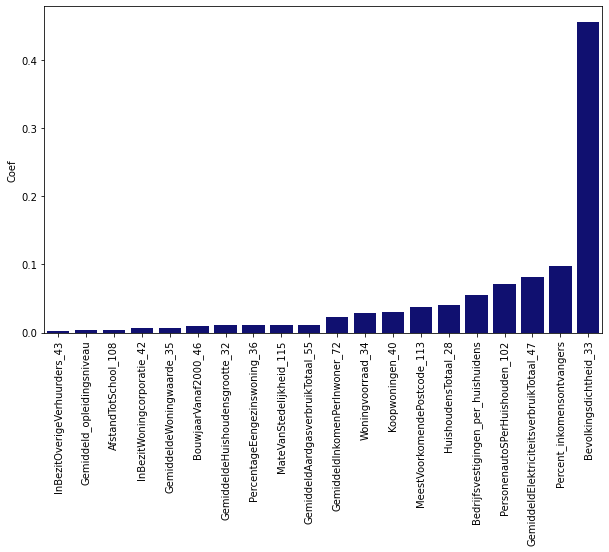

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(data = coefs_gb, x = coefs_gb.index, y = 'Coef', color = 'navy' )
plt.xticks(rotation = 90)
plt.show()

## Model using: Decision tree

In [40]:
from sklearn.tree import DecisionTreeRegressor

In [41]:
max_range = 10
for i in range(1,max_range):

    decision_tree_regressor = DecisionTreeRegressor(max_depth=i)

    pipeline_decision_tree = Pipeline([
        ('impute', imputer),
        ('scaler',StandardScaler()), 
        ('model', decision_tree_regressor)])

    pipeline_decision_tree.fit(X_train, y_train, model__sample_weight=None)
    score = pipeline_decision_tree.score(X_test, y_test)

    print("Depth  %2.f" % i, ":Score: %.2f" % score)


Depth   1 :Score: 0.34
Depth   2 :Score: 0.48
Depth   3 :Score: 0.58
Depth   4 :Score: 0.49
Depth   5 :Score: 0.48
Depth   6 :Score: 0.31
Depth   7 :Score: 0.44
Depth   8 :Score: 0.44
Depth   9 :Score: 0.42


## Model using: K nearest neighbours (KNN)

In [42]:
from sklearn.neighbors import KNeighborsRegressor

In [43]:
max_range = 15
for i in range(1,max_range):

    nearest_neighbour_regressor = KNeighborsRegressor(n_neighbors=i)

    pipeline_nearest_neighbour = Pipeline([
        ('impute', imputer),
        ('scaler',StandardScaler()), 
        ('model', nearest_neighbour_regressor)])

    pipeline_nearest_neighbour.fit(X_train, y_train)
    score = pipeline_nearest_neighbour.score(X_test, y_test)

    print("Neighbours  %2.f" % i, ":Score: %.2f" % score)

Neighbours   1 :Score: 0.14
Neighbours   2 :Score: 0.50
Neighbours   3 :Score: 0.56
Neighbours   4 :Score: 0.57
Neighbours   5 :Score: 0.56
Neighbours   6 :Score: 0.56
Neighbours   7 :Score: 0.56
Neighbours   8 :Score: 0.58
Neighbours   9 :Score: 0.59
Neighbours  10 :Score: 0.59
Neighbours  11 :Score: 0.58
Neighbours  12 :Score: 0.58
Neighbours  13 :Score: 0.58
Neighbours  14 :Score: 0.57


## Model using: Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
pipeline_rf = Pipeline([
    ('impute', imputer),
    ('scaler',StandardScaler()), 
    ('model',RandomForestRegressor())])

pipeline_rf.fit(X_train, y_train, model__sample_weight=None)
pipeline_rf.score(X_test, y_test)

0.6116430678616986

## Conclusion

The best models for the data and the selected features are:
- linear model
- lasso model
- KNN model (6 or 7 neighbours)

The decision tree and SVM model are not as good as the above mentioned ones.

The highest score is 0,43 for the linear model.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0604020-40e6-4d7d-a2ba-74ef2b385723' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

Best scenario